In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx

from pathlib import Path

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

plt.style.use(Path('~/uavsar-validation/manuscript.mplstyle'))

data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')
fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/appendix')

ds = xr.open_dataset(ncs_dir.joinpath('final_50_50.nc'))

In [4]:
insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

# get insitu info
densities = np.zeros(len(ds.time1.data))
phases = np.zeros(len(ds.time1.data))
for i, time in enumerate(ds.time1.data):
    insitu_t = insitu[insitu.time1 == time]
    density = np.mean(insitu_t[['t1_density', 't2_density']].mean(axis = 1))
    densities[i] = density
    phases[i] = np.mean(phase_from_depth(insitu_t['dSWE']*997/density, insitu_t['inc'], density = insitu_t[['t1_density', 't2_density']].mean(axis = 1)))
densities = xr.DataArray(densities,
    coords = {'time1':ds.time1.data})
phases = xr.DataArray(phases,
    coords = {'time1':ds.time1.data})

# Coherence

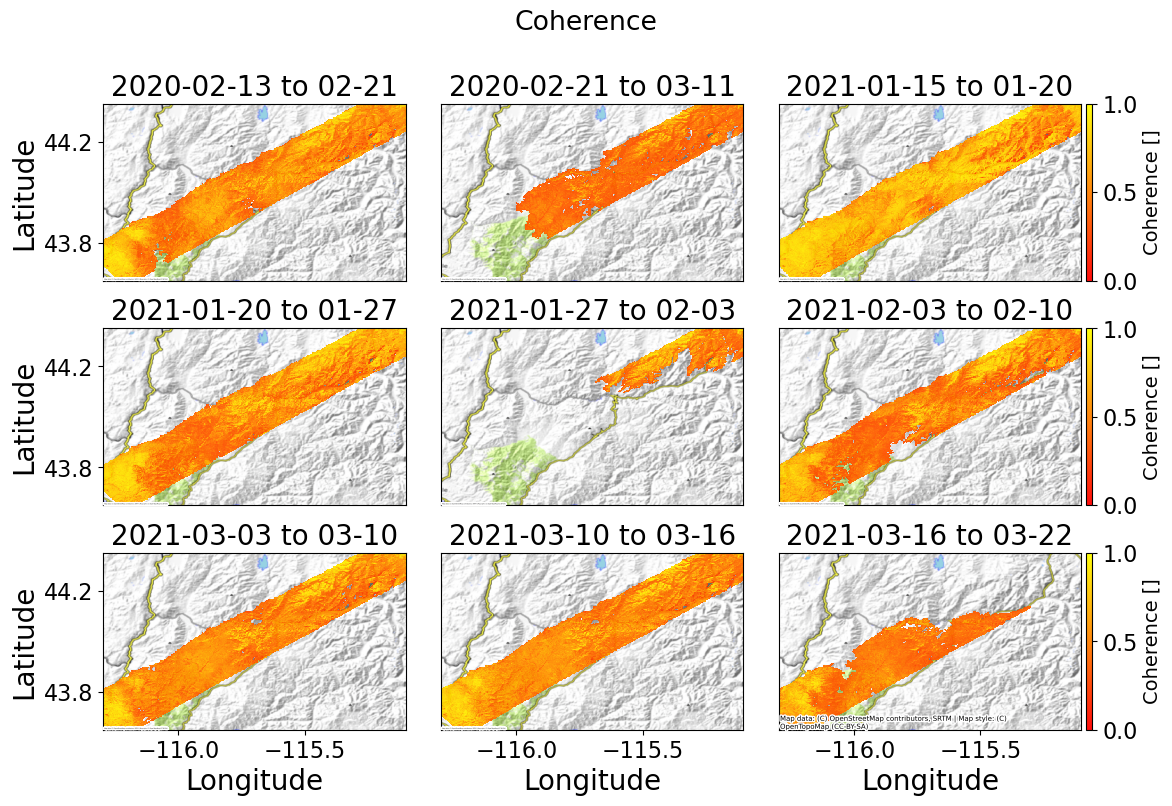

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(3,3, figsize = (12, 8))
for i, (t1, t2, ax) in enumerate(zip(ds.time1.data, ds.time2.data, axes.ravel())):
    t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
    im = ds['cor'].where(~ds['unw'].isnull()).sel(time1 = t1).plot(ax = ax, robust = True, add_colorbar = False, alpha = 0.95, vmin = 0, vmax = 1 , cmap = 'autumn') # cbar_kwargs= {'fraction':0.046, 'pad':0.04}
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    if (i - 2) % 3 == 0:    
        cbar = True    
        cb = plt.colorbar(im, cax=cax, label = 'Coherence []')
        cb.set_label(label='Coherence []', fontsize = 14)
    else:
        cax.axis('off')
        cbar = False
    ax.set_title(f"{t1.strftime('%Y-%m-%d')} to {t2.strftime('%m-%d')}", fontsize = 20)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-116.3, -115.1)
    ax.set_ylim(43.65, 44.35)
    if i != 8:
        ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source = ctx.providers.OpenTopoMap, zoom = 9, attribution_size = 1)
    else:
        ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source = ctx.providers.OpenTopoMap, zoom = 9, attribution_size = 5)

for ax in axes[:, 0]:
    ax.set_ylabel('Latitude')
    ax.set_yticks([43.8, 44.2])

for ax in axes[-1, :]:
    ax.set_xlabel('Longitude')
    ax.set_xticks([-116,-115.5])
fig.suptitle('Coherence', y = 1)

plt.tight_layout()
plt.savefig(fig_dir.joinpath('coherence_3_3.png'))

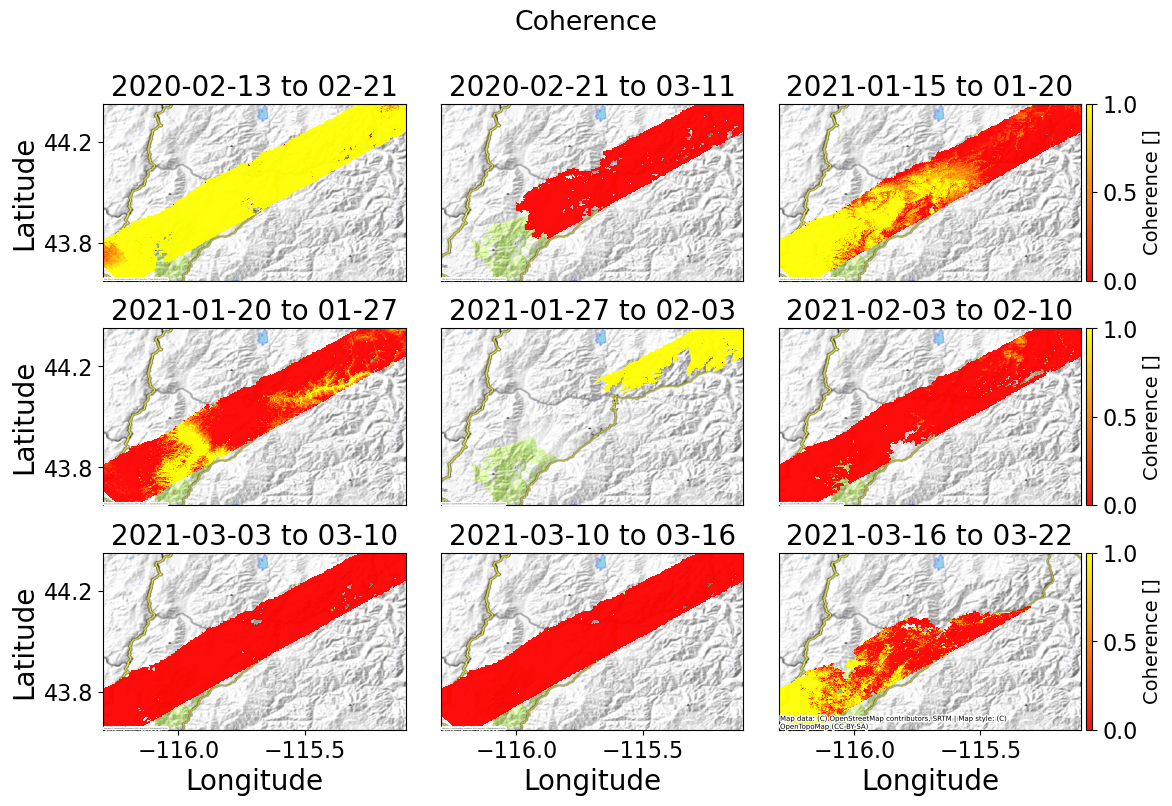

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(3,3, figsize = (12, 8))
for i, (t1, t2, ax) in enumerate(zip(ds.time1.data, ds.time2.data, axes.ravel())):
    t1, t2 = pd.to_datetime(t1), pd.to_datetime(t2)
    im = ds['int'].sel(time1 = t1).plot(ax = ax, robust = True, add_colorbar = False, alpha = 0.95 , cmap = 'autumn') # cbar_kwargs= {'fraction':0.046, 'pad':0.04}
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    if (i - 2) % 3 == 0:    
        cbar = True    
        cb = plt.colorbar(im, cax=cax, label = 'Phase [radians]')
        cb.set_label(label='Phase [radian]', fontsize = 14)
    else:
        cax.axis('off')
        cbar = False
    ax.set_title(f"{t1.strftime('%Y-%m-%d')} to {t2.strftime('%m-%d')}", fontsize = 20)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(-116.3, -115.1)
    ax.set_ylim(43.65, 44.35)
    if i != 8:
        ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source = ctx.providers.OpenTopoMap, zoom = 9, attribution_size = 1)
    else:
        ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source = ctx.providers.OpenTopoMap, zoom = 9, attribution_size = 5)

for ax in axes[:, 0]:
    ax.set_ylabel('Latitude')
    ax.set_yticks([43.8, 44.2])

for ax in axes[-1, :]:
    ax.set_xlabel('Longitude')
    ax.set_xticks([-116,-115.5])
fig.suptitle('Wrapped Phase', y = 1)

plt.tight_layout()
plt.savefig(fig_dir.joinpath('unwrapped_3_3.png'))